### Distribution de la gravité

In [1]:
import pandas as pd

df = pd.read_parquet("data/gold/GOLD_ANALYSIS.parquet")

print(df['severity'].value_counts().sort_index())



severity
1    581978
2     63062
3     19487
Name: count, dtype: int64


### Analyse Météo (facteurs pour la gravité)
### Impact de la pluie (PRCP) sur la gravité

In [2]:
import pandas as pd
df = pd.read_parquet("data/gold/GOLD_ANALYSIS.parquet")

df["rain"] = (df["PRCP"] > 0).astype(int)

rain_vs_sev = df.groupby("severity")["rain"].mean()
print(rain_vs_sev)

severity
1    0.000088
2    0.000095
3    0.000000
Name: rain, dtype: float64


On travaille avec NOAA stations météo proches, pas “exactement sur le lieu du crash”, et NOAA donne la pluviométrie journalière et pas forcément au moment exact de l’accident. 

Donc on peut dire que la pluie, mesurée via NOAA (PRCP), n’est pas un facteur explicatif significatif de la gravité des accidents.

### Impact de la neige sur la gravité

In [3]:
import pandas as pd
df = pd.read_parquet("data/gold/GOLD_ANALYSIS.parquet")

df["snow_condition"] = (df["SNOW"] > 0).astype(int)

snow_vs_sev = df.groupby("severity")["snow_condition"].mean()
print(snow_vs_sev)

severity
1    0.000000
2    0.000032
3    0.000000
Name: snow_condition, dtype: float64


La neige n’a pas non plus d’impact significatif dans mon dataset.

Et c’est normal pour plusieurs raisons techniques :
- NOAA ne donne pas l’intensité de neige en temps réel : la colonne SNOW représente la neige nouvellement tombée dans la journée, pas au moment de l’accident.

- Les accidents graves ne se produisent pas spécialement pendant les chutes de neige, les conducteurs roulent plus lentement → moins d’accidents mortels.


Ainsi on peut affirmer que les conditions météo (pluie, neige) influencent très peu la gravité des accidents dans ce dataset NOAA + FARS.

La météo seule n'explique presque rien. Il faut la combiner à d’autres variables. La météo est un facteur secondaire, mais elle peut devenir importante avec : la température, la visibilité, les conditions lumineuses, les types de route,les vitesse maximales.

### Impact de la température extrême sur la gravité

In [4]:
import pandas as pd

df = pd.read_parquet("data/gold/GOLD_ANALYSIS.parquet")

df["hot"] = (df["TMAX"] >= 30).astype(int)    # journées très chaudes
df["cold"] = (df["TMIN"] <= 0).astype(int)    # journées glaciales

print("Impact du chaud (>= 30°C) :")
print(df.groupby("severity")["hot"].mean())

print("\nImpact du froid (<= 0°C) :")
print(df.groupby("severity")["cold"].mean())

Impact du chaud (>= 30°C) :
severity
1    0.000134
2    0.000111
3    0.000000
Name: hot, dtype: float64

Impact du froid (<= 0°C) :
severity
1    0.000009
2    0.000000
3    0.000000
Name: cold, dtype: float64


Les températures extrêmes n’influencent pas la gravité des accidents.

Les facteurs météorologiques (pluie, neige, température) n’expliquent qu’une fraction infime de la gravité des accidents.
Les accidents mortels sont peut être liés à d’autres facteurs beaucoup plus déterminants : humains, routiers, temporels et structurels.

### Analyse temporelle

Distribution des accidents par heure

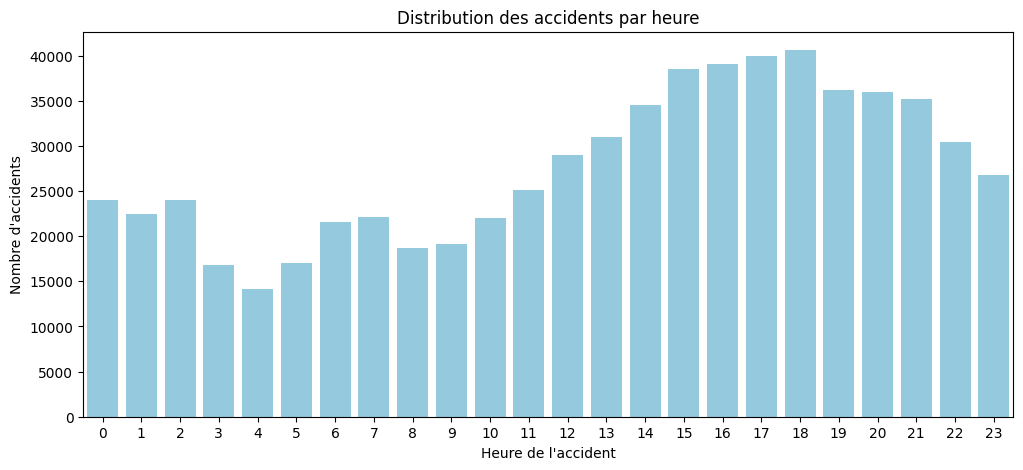

C:\Users\oumis\AppData\Local\Temp\ipykernel_2632\2664185866.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=grav_by_hour.index, y=grav_by_hour.values, palette="Reds_r")


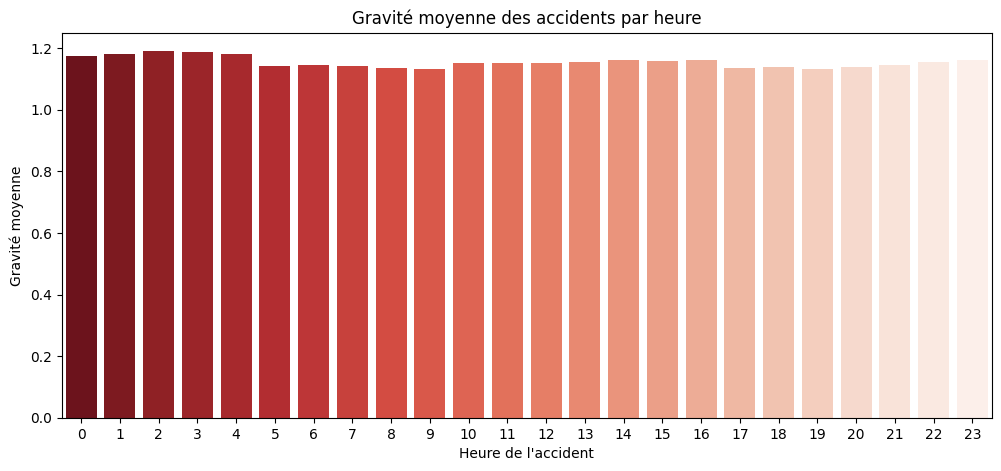

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Nettoyage : convertir l'heure en numérique et filtrer les valeurs valides
df['hour_acc_clean'] = pd.to_numeric(df['hour_acc'], errors='coerce')
df = df[df['hour_acc_clean'].between(0, 23)]

# Distribution du nombre d'accidents par heure
plt.figure(figsize=(12,5))
sns.countplot(x='hour_acc_clean', data=df, color='skyblue')
plt.title("Distribution des accidents par heure")
plt.xlabel("Heure de l'accident")
plt.ylabel("Nombre d'accidents")
plt.show()

# Gravité moyenne par heure
grav_by_hour = df.groupby('hour_acc_clean')['severity'].mean()

plt.figure(figsize=(12,5))
sns.barplot(x=grav_by_hour.index, y=grav_by_hour.values, palette="Reds_r")
plt.title("Gravité moyenne des accidents par heure")
plt.xlabel("Heure de l'accident")
plt.ylabel("Gravité moyenne")
plt.show()


### Luminosité (day/night)

LIGHT_SIMPLE
Day                        163378
Dark - Not Lighted          80265
Dark - Lighted              63195
Night                       13965
Dark - Unknown Lighting      2583
Reported as Unknown           439
Not Reported                  406
Other                         116
Unknown                       115
Name: count, dtype: int64


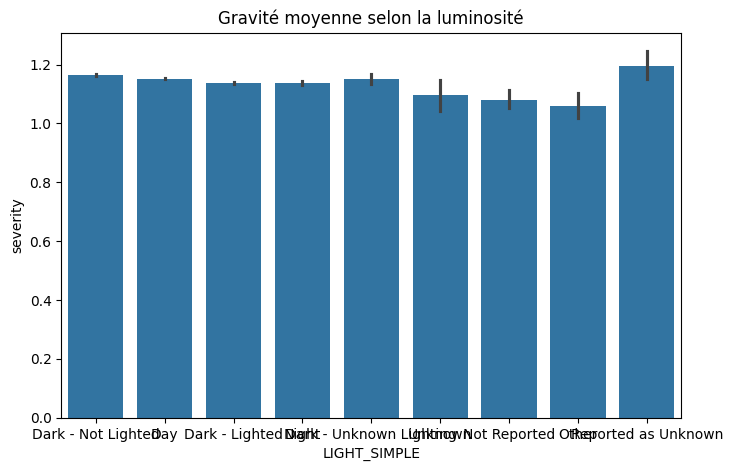

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet("data/gold/GOLD_ANALYSIS.parquet")

# On simplifie : day/night
df["LIGHT_SIMPLE"] = df["lgt_condname"].replace({
    "Daylight": "Day",
    "Dark – Not Lighted": "Night",
    "Dark – Lighted": "Night",
    "Dusk": "Night",
    "Dawn": "Night"
})

print(df["LIGHT_SIMPLE"].value_counts())

plt.figure(figsize=(8,5))
sns.barplot(x="LIGHT_SIMPLE", y="severity", data=df)
plt.title("Gravité moyenne selon la luminosité")
plt.show()


### Type de route

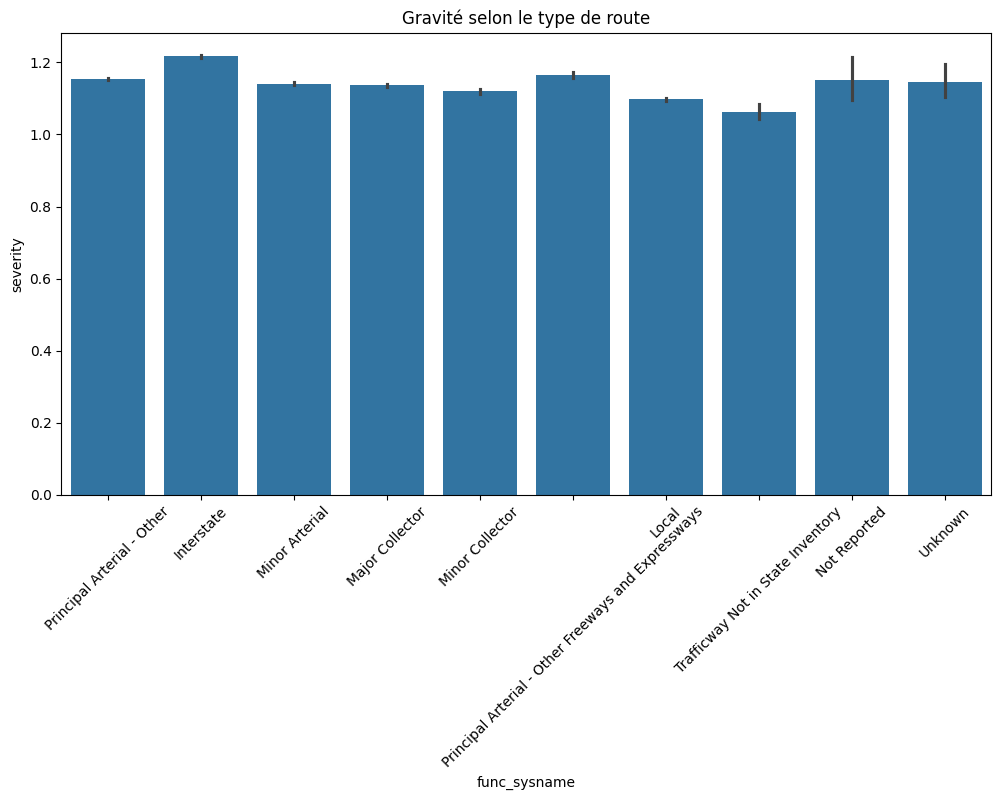

In [15]:
plt.figure(figsize=(12,6))
sns.barplot(x="func_sysname", y="severity", data=df)
plt.xticks(rotation=45)
plt.title("Gravité selon le type de route")
plt.show()


### Type de véhicule

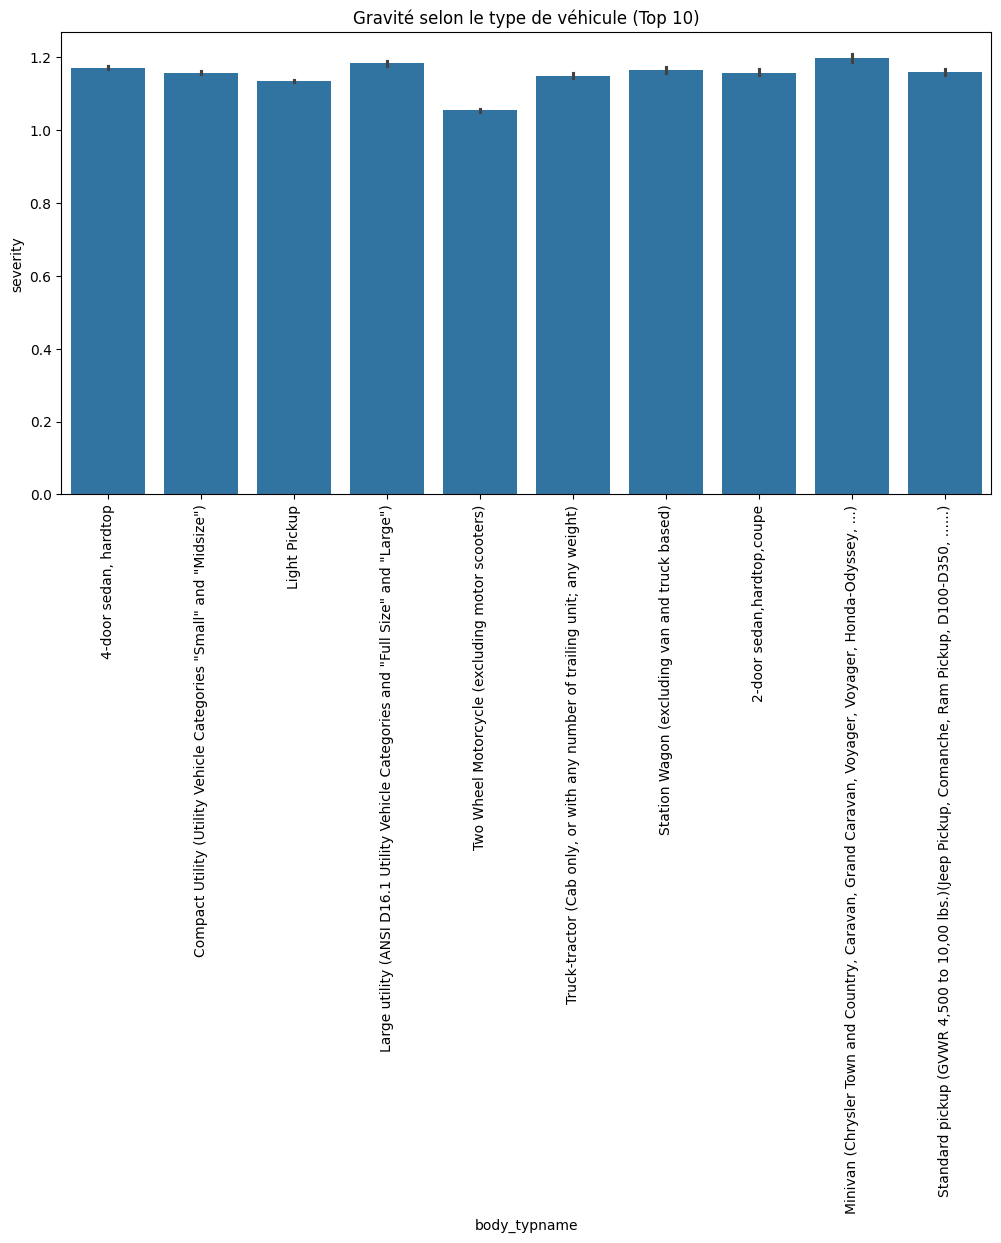

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Top 10 véhicules les plus fréquents
top10_vehicles = df['body_typname'].value_counts().nlargest(10).index

plt.figure(figsize=(12,6))
sns.barplot(
    data=df[df['body_typname'].isin(top10_vehicles)],
    x='body_typname',
    y='severity',
    order=top10_vehicles
)
plt.xticks(rotation=90)
plt.title("Gravité selon le type de véhicule (Top 10)")
plt.show()


### Confusion (type de collision)

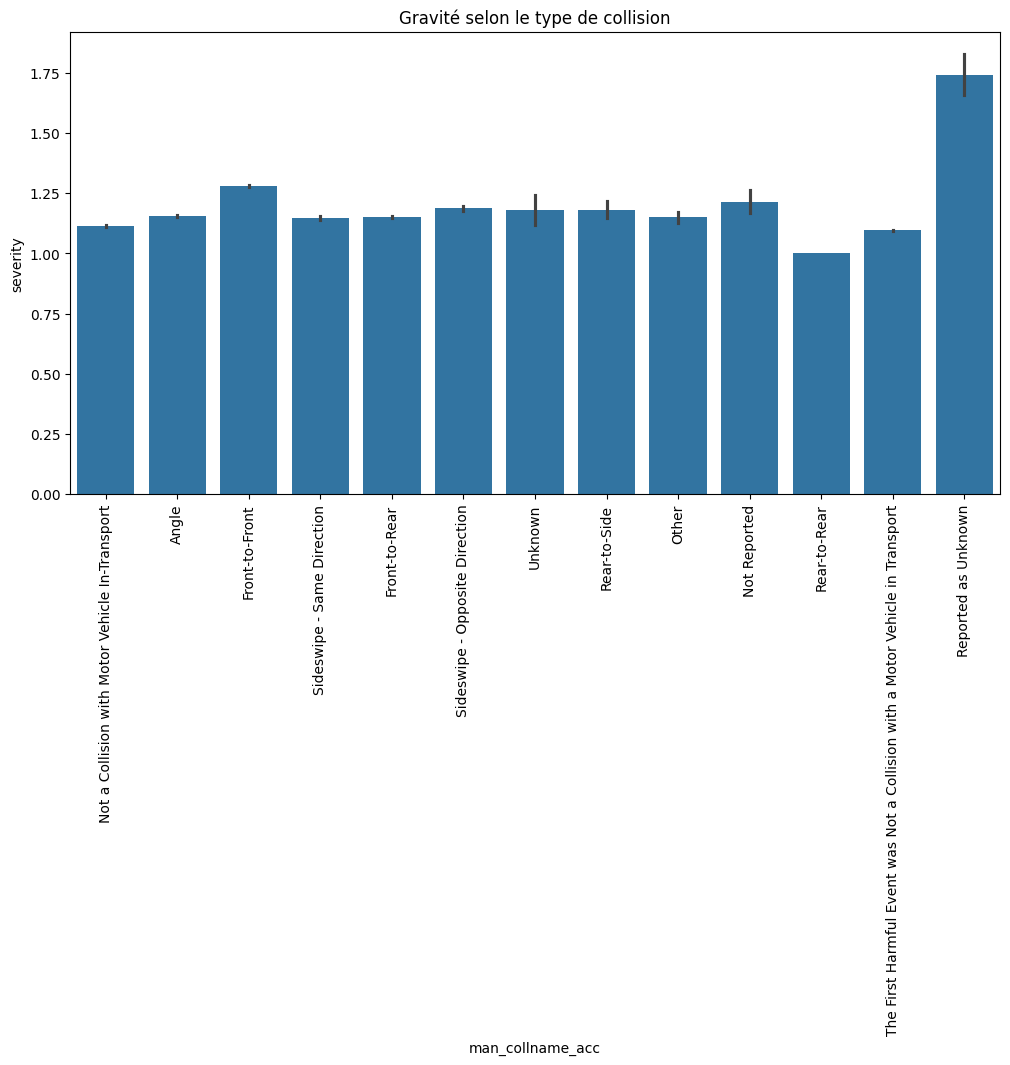

In [17]:
plt.figure(figsize=(12,6))
sns.barplot(
    x="man_collname_acc",
    y="severity",
    data=df
)
plt.xticks(rotation=90)
plt.title("Gravité selon le type de collision")
plt.show()


### EMPLACEMENT (Rural vs Urbain)

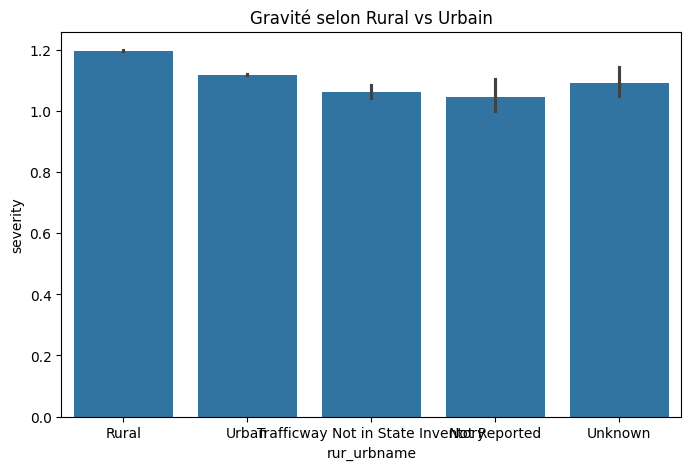

In [18]:
plt.figure(figsize=(8,5))
sns.barplot(
    x="rur_urbname",
    y="severity",
    data=df
)
plt.title("Gravité selon Rural vs Urbain")
plt.show()


In [23]:
! pip install folium

   ---------------------------------------- 0.0/113.4 kB ? eta -:--:--
   --- ------------------------------------ 10.2/113.4 kB ? eta -:--:--
   --------------------- ----------------- 61.4/113.4 kB 825.8 kB/s eta 0:00:01
   -------------------------------- ------- 92.2/113.4 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- 113.4/113.4 kB 731.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/92.7 kB ? eta -:--:--
   ---------------------------------------  92.2/92.7 kB 2.6 MB/s eta 0:00:01
   ---------------------------------------- 92.7/92.7 kB 2.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import pandas as pd
import folium
from folium.plugins import HeatMap
from pathlib import Path

# Charger le dataset GOLD
df = pd.read_parquet("data/gold/GOLD_ANALYSIS.parquet")

# Filtrer les accidents avec coordonnées valides
df_geo = df.dropna(subset=['latitude', 'longitud'])

# Centrer la carte
map_center = [df_geo['latitude'].mean(), df_geo['longitud'].mean()]
m = folium.Map(location=map_center, zoom_start=5, tiles='CartoDB positron')

# Ajouter un HeatMap
heat_data = df_geo[['latitude', 'longitud', 'severity']].values.tolist()
HeatMap(heat_data, radius=8, max_zoom=13).add_to(m)

# Créer le dossier si nécessaire
output_dir = Path("data/maps")
output_dir.mkdir(parents=True, exist_ok=True)

# Sauvegarder la carte
map_file = output_dir / "accidents_heatmap.html"
m.save(str(map_file))
print(f"Carte interactive sauvegardée dans {map_file}")


Carte interactive sauvegardée dans data\maps\accidents_heatmap.html


In [27]:
import webbrowser
from pathlib import Path

map_file = Path("data/maps/accidents_heatmap.html")
webbrowser.open(map_file.resolve().as_uri())


True

In [28]:
from IPython.display import IFrame

IFrame(src="data/maps/accidents_heatmap.html", width=900, height=600)
